In [1]:
import matplotlib.pyplot as plt

from data.LSA_Dataset import LSA_Dataset
from data.transforms import (get_frames_reduction_transform,
    get_roi_selector_transform,
    get_keypoint_format_transform,
    get_text_to_tensor_transform,
    keypoints_norm_to_nose,
    interpolate_keypoints)

In [2]:
root = '/mnt/data/datasets/LSA-T/data/cuts'
max_frames = 75
keypoints_to_use = [i for i in range(94, 136)]

dataset = LSA_Dataset(
    root,
    mode = 'train',
    load_videos = False,
    words_min_freq = 5,
    signer_confidence_threshold = 0.5,
    frame_transform = get_roi_selector_transform(128,128),
    video_transform = get_frames_reduction_transform(max_frames),
    keypoints_transform = get_frames_reduction_transform(max_frames),
    keypoints_transform_each = get_keypoint_format_transform(keypoints_to_use)
    )
dataset.label_transform = get_text_to_tensor_transform(dataset.vocab.__getitem__("<bos>"), dataset.vocab.__getitem__("<eos>"))

In [3]:
import random

i = random.randint(0, dataset.__len__())
sample = dataset.__getitem__(i)

In [7]:
print(sample[3])
clip = sample[1]
print("[F, C, H, W]", clip.size())
plt.figure(figsize=(12, 12))
for i in range(20):
    plt.subplot(5, 5, i + 1)
    iclip = clip[i, ...].permute(1,2,0)
    plt.imshow(iclip)
    plt.axis("off")

AttributeError: 'list' object has no attribute 'tokens'

In [4]:
keys = list(sample[1])

In [5]:
from torch import stack

print(sample[2])

print(len(keys))
print(keys[0].size())

vid_keys = stack(keys)
print(vid_keys.size())


tensor([   2,   90,   37,  185, 2202,   11,  621,   10,   39,  135,    4,    3])
75
torch.Size([3, 42])
torch.Size([75, 3, 42])


In [9]:
from torch.utils.data import DataLoader
from data.collate_fn import get_keypoint_model_collate_fn

dl = DataLoader(dataset, 12, collate_fn=get_keypoint_model_collate_fn(dataset.vocab.__getitem__("<pad>")))
for b in dl:
    print(type(b[0][0]))
    print(len(b[0][0]))
    break

<class 'list'>
75


In [3]:
from typing import List
from torch import Tensor, nn

from model.modules.KeypointsEmbedding import KeypointsEmbedding
from model.modules.PositionalEncoding import PositionalEncoding
from model.modules.TokenEmbedding import TokenEmbedding


class KeypointModel(nn.Module):

    def __init__(self,
                src_max_len: int,
                tgt_max_len: int,
                keys_len: int,
                tgt_vocab_size: int,
                kernel_size: int = 5,
                emb_size: int = 64,
                keys_initial_emb_size: int = 128,
                ):
        super(KeypointModel, self).__init__()

        # in_features is the result of flattening the input of (x,y,c).(k1, ..., k42)
        self.keys_emb = KeypointsEmbedding(keys_len=keys_len, kernel_size=kernel_size, emb_size=emb_size, keys_initial_emb_size=keys_initial_emb_size)
        self.src_pe = PositionalEncoding(emb_size=emb_size, max_len=(src_max_len - kernel_size + 1))
        self.tgt_tok_emb = TokenEmbedding(tgt_vocab_size, emb_size)
        self.tgt_pe = PositionalEncoding(emb_size=emb_size, max_len=tgt_max_len)
        self.transformer = nn.Transformer(d_model=emb_size)
        self.generator = nn.Linear(emb_size, tgt_vocab_size)
        

    def forward(self,
                src: List[Tensor],
                tgt: Tensor,
                src_mask: Tensor,
                tgt_mask: Tensor,
                src_padding_mask: Tensor,
                tgt_padding_mask: Tensor,
                memory_key_padding_mask: Tensor):
        src_emb = self.src_pe(self.keys_emb(src))
        tgt_emb = self.tgt_pe(self.tgt_tok_emb(tgt))
        outs = self.transformer(src_emb, tgt_emb, src_mask, tgt_mask, None,
                                src_padding_mask, tgt_padding_mask, memory_key_padding_mask)
        return self.generator(outs)

    def encode(self, src: Tensor, src_mask: Tensor):
        return self.transformer.encoder(self.src_pe(self.keys_emb(src)), src_mask)

    def decode(self, tgt: Tensor, memory: Tensor, tgt_mask: Tensor):
        return self.transformer.decoder(self.tgt_pe(self.tgt_tok_emb(tgt)), memory, tgt_mask)

In [ ]:
torch.manual_seed(0)

SRC_MAX_LEN = max_frames
TGT_VOCAB_SIZE = len(dataset.vocab)
EMB_SIZE = 512
NHEAD = 8
FFN_HID_DIM = 512
BATCH_SIZE = 128
NUM_ENCODER_LAYERS = 3
NUM_DECODER_LAYERS = 3


transformer = KeypointModel(NUM_ENCODER_LAYERS, NUM_DECODER_LAYERS, EMB_SIZE,
                                 NHEAD, SRC_VOCAB_SIZE, TGT_VOCAB_SIZE, FFN_HID_DIM)

for p in transformer.parameters():
    if p.dim() > 1:
        nn.init.xavier_uniform_(p)

transformer = transformer.to(DEVICE)

loss_fn = torch.nn.CrossEntropyLoss(ignore_index=PAD_IDX)

optimizer = torch.optim.Adam(transformer.parameters(), lr=0.0001, betas=(0.9, 0.98), eps=1e-9)

In [21]:
print(model(vid_keys, None).size())

torch.Size([71, 1, 32])


In [4]:
import torch

def generate_square_subsequent_mask(sz):
    mask = (torch.triu(torch.ones((sz, sz))) == 1).transpose(0, 1)
    mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
    return mask

print(generate_square_subsequent_mask(5))

tensor([[0., -inf, -inf, -inf, -inf],
        [0., 0., -inf, -inf, -inf],
        [0., 0., 0., -inf, -inf],
        [0., 0., 0., 0., -inf],
        [0., 0., 0., 0., 0.]])


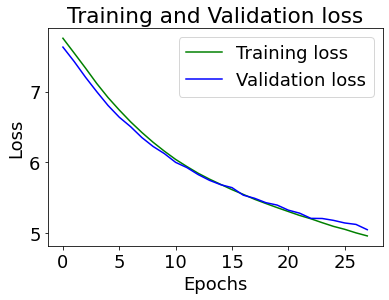

In [33]:
import os
from typing import Optional
from pathlib import Path
import torch

from type_hints import ModelCheckpoint

CHECKPOINT_PATH = Path("checkpoints")
#checkpoint: Optional[ModelCheckpoint] = torch.load(sorted((CHECKPOINT_PATH.glob('*.tar')), reverse=True)[0])
checkpoint = torch.load(CHECKPOINT_PATH / "checkpoint_28_epochs_5_min_freq_05_conf_threshold.tar")
#checkpoint = torch.load(CHECKPOINT_PATH / "checkpoint_30_epochs.tar")


loss_train = checkpoint['train_loss_hist']
loss_val = checkpoint['val_loss_hist']
plt.rcParams.update({'font.size': 18})
plt.plot(loss_train, 'g', label='Training loss')
plt.plot(loss_val, 'b', label='Validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [41]:
root = '/mnt/data/datasets/LSA-T/data/cuts'
max_frames = 75
batch_size = 128
keypoints_to_use = [i for i in range(94, 136)]
words_min_freq = 5
confidence_threshold = 0.5
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
CHECKPOINT_PATH = Path("checkpoints/")
CHECKPOINT_PATH.mkdir(exist_ok=True)

#wandb.init(project="all-db-train", entity="pedroodb")

keypoints_transform = Compose([
    get_frames_reduction_transform(max_frames),
    interpolate_keypoints
])
keypoints_transform_each = Compose([
    get_keypoint_format_transform(keypoints_to_use),
    keypoints_norm_to_nose
])

print("Loading train dataset")
train_dataset = LSA_Dataset(
    root,
    mode = "train",
    words_min_freq = words_min_freq,
    signer_confidence_threshold = confidence_threshold,
    label_as_idx = False,
    load_videos = False,
    keypoints_transform = keypoints_transform,
    keypoints_transform_each = keypoints_transform_each
)

checkpoint = torch.load(CHECKPOINT_PATH / "checkpoint_28_epochs_5_min_freq_05_conf_threshold.tar")
model = KeypointModel(max_frames, train_dataset.max_label_len + 2, len(keypoints_to_use), len(train_dataset.vocab)).to(DEVICE)
model.load_state_dict(checkpoint['model_state_dict'])


Loading train dataset


<All keys matched successfully>

In [36]:
from typing import Callable


def edit_distance(prediction_tokens: list[str], reference_tokens: list[str], ignore_tokens: list[str] = []) -> int:
    """Standard dynamic programming algorithm to compute the edit distance adding a list of tokens to ignore
    Args:
        prediction_tokens: A tokenized predicted sentence
        reference_tokens: A tokenized reference sentence
        ignore_tokens: Tokens to ignore substitutions and insertions
    Returns:
        Edit distance between the predicted sentence and the reference sentence, ignoring insertions and substitutions of ignore_tokens
    """
    dp = [[0] * (len(reference_tokens) + 1) for _ in range(len(prediction_tokens) + 1)]
    for i in range(len(prediction_tokens) + 1):
        dp[i][0] = i
    for j in range(1, len(reference_tokens) + 1):
        dp[0][j] = dp[0][j - 1] + (1 if reference_tokens[j - 1] not in ignore_tokens else 0)
    for i in range(1, len(prediction_tokens) + 1):
        for j in range(1, len(reference_tokens) + 1):
            dp[i][j] = min(
                dp[i - 1][j] + 1,
                dp[i][j - 1] + (1 if reference_tokens[j - 1] not in ignore_tokens else 0),
                dp[i - 1][j - 1] + (1 if prediction_tokens[i - 1] != reference_tokens[j - 1]
                                        and reference_tokens[j - 1] not in ignore_tokens else 0)
            )
    return dp[-1][-1]

def wer_n(prediction: str, target: str, ignore_tokens: list[str], tokenizer: Callable[[str], list[str]] = str.split) -> float:
    return edit_distance(tokenizer(prediction), tokenizer(target), ignore_tokens) / len(tokenizer(target))

In [42]:
dataset = train_dataset

labels: list[str] = []
preds: list[str] = []
for i in range(0, dataset.__len__()):
    if i % 100 == 0:
        print(f"{i}/{len(dataset)}")
    _, keys, label = dataset.__getitem__(i)
    res = translate(model, keys, dataset, DEVICE)
    preds.append(res)
    labels.append(' '.join(label))
    #print(i, res, ' '.join(label))

0/3767
100/3767
200/3767
300/3767
400/3767
500/3767
600/3767
700/3767
800/3767
900/3767
1000/3767
1100/3767
1200/3767
1300/3767
1400/3767
1500/3767
1600/3767
1700/3767
1800/3767
1900/3767
2000/3767
2100/3767
2200/3767
2300/3767
2400/3767
2500/3767
2600/3767
2700/3767
2800/3767
2900/3767
3000/3767
3100/3767
3200/3767
3300/3767
3400/3767
3500/3767
3600/3767
3700/3767


In [20]:
preds, labels = [], []
with open("preds/train/preds.txt") as f:
    for line in f:
        preds.append(line[:-1])
with open("preds/train/labels.txt") as f:
    for line in f:
        labels.append(line[:-1])
print(len(preds))
print(preds[:5])
print(labels[:5])

11931
[' ¿ cómo es el personas ? ', ' el comunidad . ', ' el comunidad . ', ' ¿ cómo es el personas ? ', ' ¿ cómo es el personas ? ']
['a disfrutar el día todos los padres de argentina .', 'nos interesa continuar estudiando y capacitarnos en todo lo que conlleva', 'una tradición argentina que se realiza todos los años en el mes de marzo .', 'hay que seguir cuidándose como siempre .', 'quisimos adentrarnos en la temática , conocer distintos sabores y demás .']


In [43]:
from collections import Counter
from statistics import mean

freqs = Counter([word for label in labels for word in label.split(' ')])
singletons = [word for (word, freq) in freqs.items() if freq <= 1]
singletons5 = [word for (word, freq) in freqs.items() if freq <= 5]
singletons10 = [word for (word, freq) in freqs.items() if freq <= 10]

wer = mean([wer_n(preds[i], labels[i], []) for i in range(len(labels))])
wer1 = mean([wer_n(preds[i], labels[i], singletons) for i in range(len(labels))])
wer5 = mean([wer_n(preds[i], labels[i], singletons5) for i in range(len(labels))])
wer10 = mean([wer_n(preds[i], labels[i], singletons10) for i in range(len(labels))])

print(wer)
print(wer1)
print(wer5)
print(wer10)

0.9548790378180836
0.9397863627884643
0.8324705649744524
0.7536014772170618


In [40]:
import os

with open('preds/reduced/preds.txt','w') as preds_f:
    preds_f.writelines(map(lambda p: p+'\n', preds))
with open('preds/reduced/labels.txt','w') as labels_f:
    labels_f.writelines(map(lambda p: p+'\n', labels))

In [28]:
from collections import Counter
from typing import Callable
from torchmetrics.functional import word_error_rate, bleu_score

def get_remove_singletons(singletons: list[str]) -> Callable[[str], str]:
    def remove_singletons(label: str) -> str:
        return ' '.join([word for word in label.split(' ') if word not in singletons])
    return remove_singletons

freqs = Counter([word for label in labels for word in label.split(' ')])
singletons = [word for (word, freq) in freqs.items() if freq <= 10]
remove_singletons = get_remove_singletons(singletons)

clean_labels: list[str] = []
diff_labels: list[tuple[int, str, str]] = []
for i, label in enumerate(labels):
    clean_label = remove_singletons(label)
    clean_labels.append(clean_label)
    if label != clean_label:
        diff_labels.append((i, label, clean_label))
clean_preds = list(map(get_remove_singletons(singletons), preds))

no_sing_preds, no_sing_labels = zip(
    *map(lambda i_l: (preds[i_l[0]], i_l[1]),
    filter(lambda i_l: not any(w in singletons for w in i_l[1].split(' ')), enumerate(labels))))

wer = word_error_rate(preds, labels)
bleu = bleu_score(preds, labels)
wer_no_sing = word_error_rate(preds, clean_labels)
bleu_no_sing = bleu_score(preds, clean_labels)
wer_no_sing_samples = word_error_rate(list(no_sing_preds), list(no_sing_labels))
bleu_no_sing_samples = bleu_score(preds, clean_labels)

In [29]:
print(f"{len(diff_labels)}/{len(labels)}")
print(f"{len(no_sing_labels)}/{len(labels)}")
print(wer, bleu)
print(wer_no_sing, bleu_no_sing)
print(wer_no_sing_samples, bleu_no_sing_samples)

3043/3767
724/3767
tensor(0.9312) tensor(0.)
tensor(0.9150) tensor(0.)
tensor(0.9187) tensor(0.)
